The goal of this notebook is to study the classification problem with the formalism and theory studied in the article "On the Validation of Gibbs Algorithms: Training Datasets, Test Datasets and their Aggregation". In the following study, the function we are trying to approximate is the indicator of a subpart of [1,m] where m is a natural integer.

# Create three datasets with various noises levels

In [3]:
import numpy as np
import random as rd

# parameters

m = 10  # cardinal of X
Lambda = 1  # regularization parameter
N = 100 # dataset size

# generate data

z1 = []      

for i in range(N):
    j = np.random.randint(1,m)
    if j%2 == 0:
        a = np.random.binomial(1,0.01)
        z1.append((j,a))
    else:
        a = np.random.binomial(1,0.99)
        z1.append((j,a))
        
z2 = []
for i in range(N):
    j = np.random.randint(1,m)
    if j%2 == 0:
        a = np.random.binomial(1,0.01)
        z2.append((j,a))
    else:
        a = np.random.binomial(1,0.99)
        z2.append((j,a))

z0 = z1 + z2 



Define the functions needed to compute the expected empirical risk

In [4]:
# define a function that generates the list of all the indicators of P([1,m]) implemented as lists of 0 and 1 (m)

def indicators(m): 
    # iterative function with complexity O(2^m)
    res = [[0],[1]]
    for i in range(m-1):
        l = []
        for ind in res:
            l.append([0]+ind)
            l.append([1]+ind)
        res = l
    return res
    
M = indicators(m)

# define the indicator prediction function with parameter theta

def indicator(theta,x):   
    return theta[x]

# define the loss function

def loss_function(y1,y2):
    return (y1 == y2)

# define the approximation function, its complexity is O(m)

def empirical_risk(theta,z):
    res = 0
    for elt in z:
        x = elt[0]
        y = elt[1] 
        if indicator(theta,x) != y:
            res += 1
    return (res/len(z))




We can solve the ERM problem with a brute force method 

In [5]:
"""This naive method has a complexity O(Nx2^m)"""

def solve_ERM(z):
    min = empirical_risk(M[0],z)
    theta_min = [M[0]]
    for theta in M:
        if empirical_risk(theta,z) == min:
            theta_min.append(theta)
        if empirical_risk(theta,z)<min:
            min = empirical_risk(theta,z)
            theta_min = [theta]
    return theta_min

The article studies another method, rather than determining a parameter vector, we seek the probability distribution of this vector. This probability distribution is the solution to the ERM-RER problem studied in the article.

In [6]:
# we need to identify the elements of M to hashable objects, so we create a bijection between M and the set [1,2^m]

def indicator_to_int(theta):  
    res = 1
    for i in range(m):
        res += theta[i]*(2**(m-i-1))
    return res
      

# define the entropy function between 2 measures P1 and P2, the complexity is O(m2^m)

def entropy(P1,P2): #P1 et P2 sont des dictionnaires qui ont pour clés les singletons {theta} et pour valeur la mesure de ce singleton, la complexité est O(m2^m)
    res = 0
    for theta in M:
        key = indicator_to_int(theta)
        res += P1[key]*np.log(P1[key]/P2[key])
    return res

def uniform(): # create the uniform measure on M, the complexity is O(2^m)
    dico = {}
    for i in range(1,2**m +1):
        dico[i] = 1/(2^m)
    return dico

# compute the Expected Empirical Risk with complexity O(N2^m)

def expected_empirical_risk(P,z):
    res = 0
    for theta in M:
        ER = empirical_risk(theta,z)
        key = indicator_to_int(theta)
        res += ER * P[key] 
    res = res
    return res

# define the function that solves the ERM-RER problem with uniform measure Q, the complexity is O((m+N)2^m)

def solve_ERM_RER(z,Lambda):
    dico = {}
    normalisation = 0
    for theta in M:
        normalisation += np.exp((-1)*(empirical_risk(theta,z)/Lambda))
    for theta in M:
        key = indicator_to_int(theta)
        dico[key] = (np.exp((-1)*(empirical_risk(theta,z)/Lambda)))/normalisation
    return dico





Let's visualize the probability distribution, for that we display the heatmap of the ERM-RER solution for several values of Lambda. We observe a concentration of the measure around the ERM solution when Lambda tends to 0.

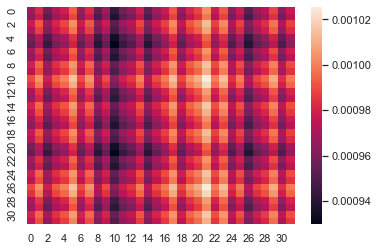

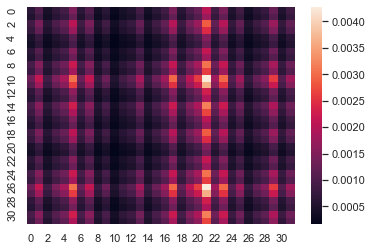

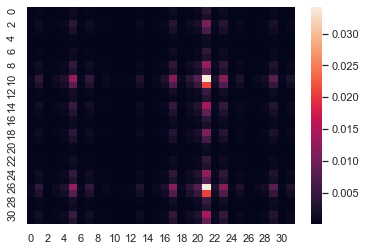

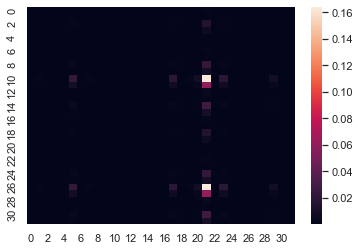

In [7]:
"""Visualization of the ERM-RER problem solution for different values of Lambda and comparison with the ERM problem solution"""

import seaborn as sns
import matplotlib.pyplot as plt

def visualization_ERM_RER(z,Lambda):
    dico = solve_ERM_RER(z,Lambda)

    matrix = np.zeros((2**(m//2),2**(m//2)))
    for i in range(2**(m//2)):
        for j in range(2**(m//2)):
            matrix[i][j] = dico[i*(2**(m//2))+j+1]
    sns.set()
    ax = sns.heatmap(matrix)
    plt.title('Lambda = '+str(Lambda))
    plt.show()

for Lambda in [10,0.3,0.1,0.05]:
    visualization_ERM_RER(z1,Lambda)



The following cell studies the question of the aggregate of datasets. Is it better to solve ERM-RER on two datasets separately and calculate the average measure of the two solutions or to solve ERM-RER on the merged dataset?

In [8]:
# let's compute the ERM_RER solution for the datasets z1, z2 and z0

import time

# time computation for P1

start = time.time()

P1 = solve_ERM_RER(z1,Lambda)

end = time.time()
elapsed = end - start

print(f'Execution time for P1 : {elapsed:.2}ms')

# time computation for P2

start = time.time()

P2 = solve_ERM_RER(z2,Lambda)

end = time.time()
elapsed = end - start

print(f'Execution time for P2 : {elapsed:.2}ms')

# time computation for P0

start = time.time()

P0 = solve_ERM_RER(z0,Lambda)

end = time.time()
elapsed = end - start

print(f'Execution time for P0 : {elapsed:.2}ms')


def sum(P1,P2):
    dico = {}
    for key in P1.keys():
        dico[key] = P1[key] + P2[key]
    return dico

def scalar(P,alpha):
    dico = {}
    for key in P.keys():
        dico[key] = alpha * P[key]
    return dico

P3 = sum(scalar(P1,0.5),scalar(P2,0.5))


# compute the expected empirical risk for P1, P2 and P0

R1 = expected_empirical_risk(P1,z1)
R2 = expected_empirical_risk(P2,z2)
R0 = expected_empirical_risk(P0,z0)

print("R0 : " + str(R0) +" R1 : " + str(R1) +" R2 : " +str(R2))

P = [P0,P1,P2,P3]
z = [z0,z1,z2]
res = np.zeros((4,3))
for i in range(len(P)):
    for j in range(len(z)):
        res[i][j] = expected_empirical_risk(P[i],z[j])
print(res)




Execution time for P1 : 0.086ms
Execution time for P2 : 0.062ms
Execution time for P0 : 0.12ms
R0 : 0.10861252384386387 R1 : 0.10620784445283865 R2 : 0.10665570113460873
[[0.10861252 0.10910601 0.10811904]
 [0.11185993 0.10620784 0.11751201]
 [0.11212982 0.11760394 0.1066557 ]
 [0.11199487 0.11190589 0.11208385]]


Let's evaluate the probability distribution of the ERM-RER solution in one of the ERM solutions for Lambda between 0.001 and 0.1. We observe a convergence towards 0.5 because when Lambda tends towards 0, the ERM-RER solution converges towards the uniform distribution on the set of ERM solutions.

[0.5, 0.49999999999305605, 0.4999999711112088, 0.4999981365806887, 0.4999772910920421, 0.49987962151131204, 0.49960297190822645, 0.49902519677462426, 0.49803122081942786, 0.49652726224226945, 0.4944431627595707, 0.4917290332668915, 0.4883509249355453, 0.48428759683891087, 0.47952871912530665, 0.4740741142465022, 0.46793349621812197, 0.4611262773826827, 0.45368118254427203, 0.4456355598800023, 0.4370343831635887, 0.4279290021022007, 0.41837572666535916, 0.40843433767291604, 0.39816660837846113, 0.38763490686293484, 0.3769009312534187, 0.3660246120200267, 0.3550631996071488, 0.34407054230607764, 0.3330965488779472, 0.32218682291942446, 0.3113824510370332, 0.3007199241552325, 0.2902311702872166, 0.2799436774175334, 0.26988068639641705, 0.2600614355985672, 0.2505014412884631, 0.2412127999545659, 0.23220450117524302, 0.22348274175582544, 0.21505123386281036, 0.20691150164169522, 0.1990631623254096, 0.1915041891229771, 0.18423115423583514, 0.1772394512016493, 0.17052349643564974, 0.164076910

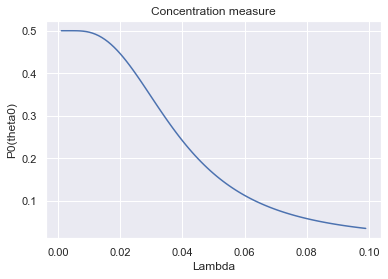

<Figure size 1152x864 with 0 Axes>

In [17]:
def visualization_concentration_measure(z,L):    # L is the list of lambda values 
    res = []
    theta0 = solve_ERM(z)[0]
    key = indicator_to_int(theta0)
    for Lambda in L:
        P0 = solve_ERM_RER(z,Lambda)
        res.append(P0[key])
    print(res)
    plt.plot(L,res)
    plt.xlabel('Lambda')
    plt.ylabel('P0(theta0)')
    plt.title('Concentration measure')
    plt.figure(figsize=(16, 12))
    plt.show

L1 = [i/1000 for i in range(1,100)]



visualization_concentration_measure(z1,L1)

# note that it converges where 0.5 because there are two ERM solutions


Study of the convergence of EER when Lambda tends towards 0, we observe that in some cases it converges towards a limit > 0 and in another it tends towards 0.

[0.010359331016220427, 0.017478282690042847, 0.03875039729837075, 0.07069147357903156, 0.10620784445283865, 0.1407261231017971, 0.17224505843852417, 0.2002091795270679, 0.22472010071401644, 0.2461273223687546, 0.2648404350850104, 0.2812510711061683, 0.29570541836567127, 0.30849873153195906, 0.3198786459814053, 0.3300514027076606, 0.3391884726241988, 0.3474326039002071, 0.3549029949382744, 0.36169958113781964, 0.36790653092750203, 0.3735950754603333, 0.3788257927840141, 0.383650452042426, 0.38811350544232387, 0.3922532990309591, 0.39610305902229515, 0.39969169866589, 0.40304448123611514, 0.40618356726540134, 0.4091284682833842, 0.41189642472716004, 0.41450272208509636, 0.41696095650922327, 0.41928325890763457, 0.42148048477447, 0.4235623756267583, 0.4255376968148101, 0.42741435559330193, 0.4291995026363033, 0.43089961961322876, 0.43252059498617773, 0.4340677898186615, 0.4355460950846871, 0.4369599817212485, 0.43831354446544113, 0.43961054035170294, 0.44085442260752994, 0.442048370572466

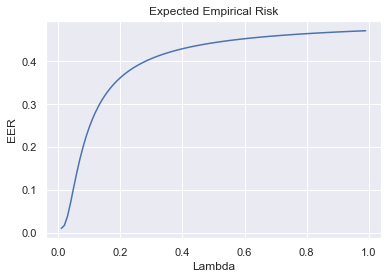

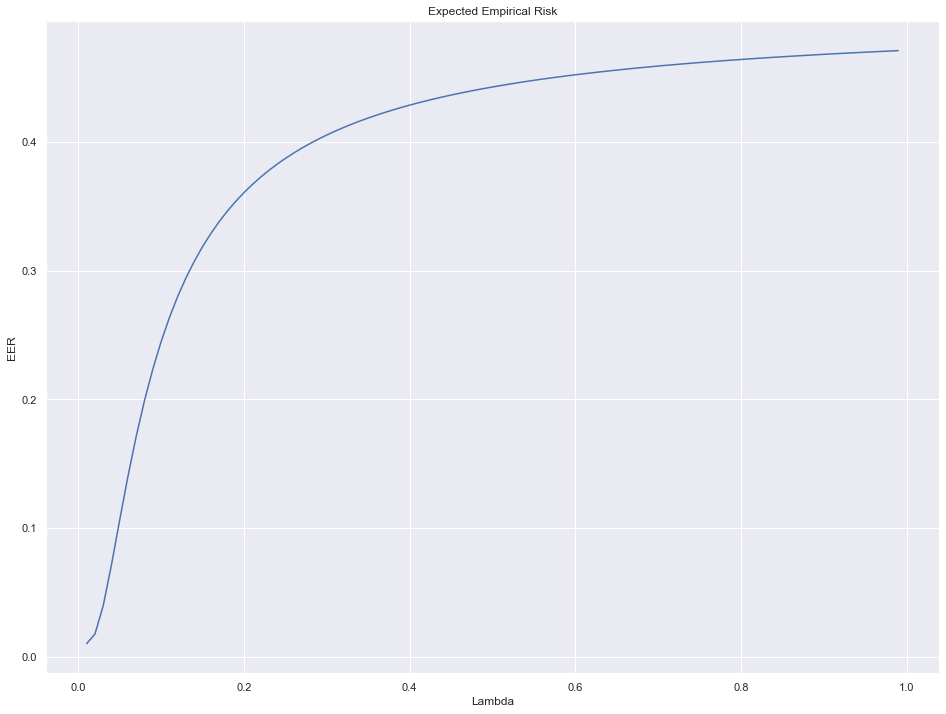

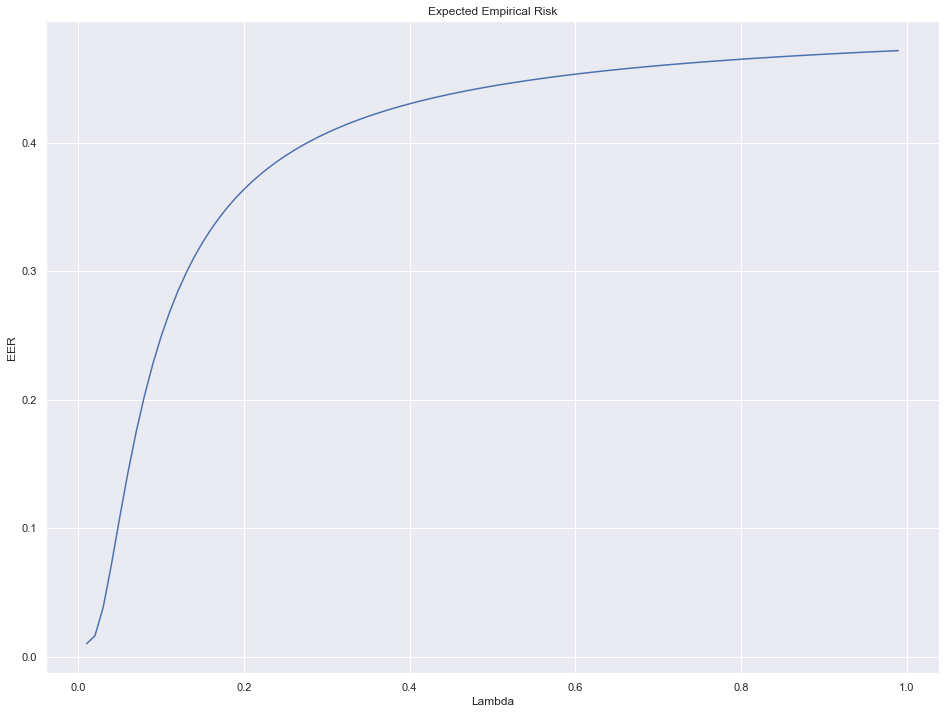

<Figure size 1152x864 with 0 Axes>

In [21]:
def visualization_EER(z,L):
    res = []
    for Lambda in L:
        P = solve_ERM_RER(z,Lambda)
        EER = expected_empirical_risk(P,z)
        res.append(EER)
    plt.plot(L,res)
    print(res)
    plt.xlabel('Lambda')
    plt.ylabel('EER')
    plt.title('Expected Empirical Risk')
    plt.figure(figsize=(16, 12))
    plt.show

L1 = [i/100 for i in range(1,100)]

visualization_EER(z1,L1)
visualization_EER(z2,L1)
visualization_EER(z0,L1)

"""we compute delta star for z1, z2 and z0, delta star is the inf of Rz(P*)"""

def delta_star(z):
    return min([empirical_risk(theta,z) for theta in M])

print("delta star 1 :" + str(delta_star(z1))+ "/    delta star 2 :" + str(delta_star(z2)) +"/    delta star 0 :" + str(delta_star(z0)))